In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


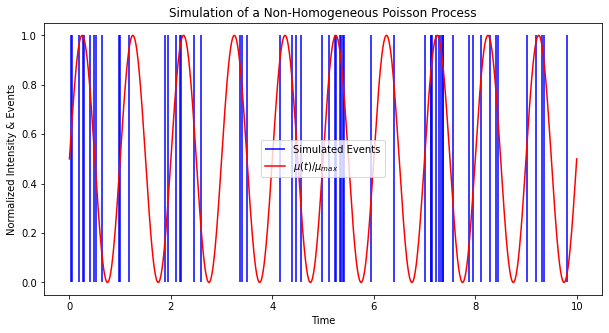

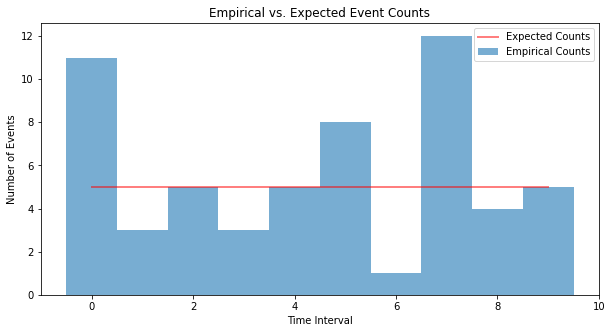

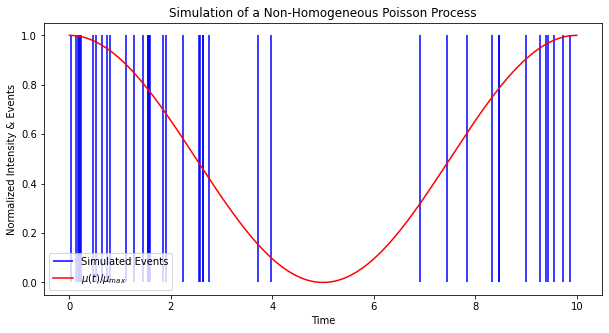

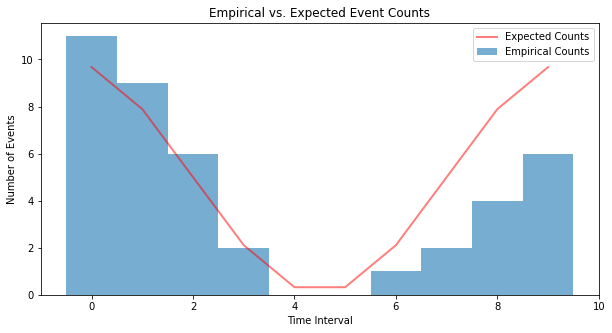

In [54]:
def simulate_nonhomogeneous_poisson(T, mu, mu_max=None):

    if mu_max is None:
        mu_max = 1.1 * max(mu(np.linspace(0, T, 1000)))
    events = []
    t = 0
    
    while t < T:
        t += np.random.exponential(1 / mu_max)
        if t >= T:
            break
        
        if np.random.uniform(0, 1) < mu(t) / mu_max:
            events.append(t)
    
    return np.array(events)


def mu(t):
    return 5 * (1 + np.sin(2 * np.pi * t))  

def mu2(t):
    return 5 * (1 + np.cos(np.pi * t * 0.2))

T = 10     
mu_max = 10  

events = simulate_nonhomogeneous_poisson(T, mu, mu_max)
events2 = simulate_nonhomogeneous_poisson(T, mu2, mu_max)

def plot(events, mu, mu_max, num_intervals = 10):
    
    if len(events) < 10 * events[-1] : 
        plt.figure(figsize=(10, 5))
        plt.vlines(events, ymin=0, ymax=1, color='b', label='Simulated Events')
        times = np.linspace(0, T, 1000)
        plt.plot(times, mu(times) / mu_max, 'r', label=r'$\mu(t) / \mu_{max}$')
        plt.xlabel('Time')
        plt.ylabel('Normalized Intensity & Events')
        plt.title('Simulation of a Non-Homogeneous Poisson Process')
        plt.legend()
        plt.show()

    intervals = np.linspace(0, T, num_intervals+1)
    empirical_counts = [np.sum((events >= intervals[i]) & (events < intervals[i+1])) for i in range(num_intervals)]
    expected_counts = [np.trapz(mu(np.linspace(intervals[i], intervals[i+1], 100)), np.linspace(intervals[i], intervals[i+1], 100)) for i in range(num_intervals)]
    plt.figure(figsize=(10, 5))
    plt.bar(range(num_intervals), empirical_counts, alpha=0.6, label='Empirical Counts', width=1.0)
    plt.plot(range(num_intervals), expected_counts, 'r-', label='Expected Counts', linewidth=2, alpha = 0.5)
    plt.xlabel('Time Interval')
    plt.ylabel('Number of Events')
    plt.legend()
    plt.title('Empirical vs. Expected Event Counts')
    plt.show()
plot(events, mu, mu_max)
plot(events2, mu2, mu_max)

This graph represent the chosen intensity for the Poisson process and the simulated event times and then the expected number of events per intervals along with the empirical count of events in our simulated data for two examples of intensity functions.
We see that the empirical count roughly follows the expected counts and the time between 2 events is shorter when the intensity is high. 

In [55]:
def plot_event_density(df, title):
    df['minutes'] = df['ets'].dt.hour*60 + df['ets'].dt.minute + df['ets'].dt.second / 60.0
    
    plt.figure(figsize=(10, 5))
    plt.hist(df['minutes'], bins=24*60, density=True, alpha=0.6, color='b', edgecolor='black')
    plt.xlabel('Minute of the Day')
    plt.ylabel('Density')
    plt.title('Intensity of occurence of trades throughout the day for day ' + title[3:11])
    plt.show()

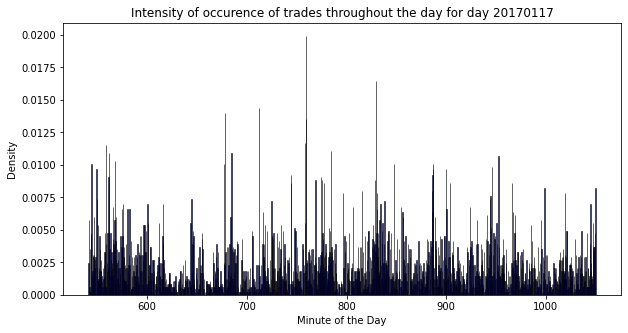

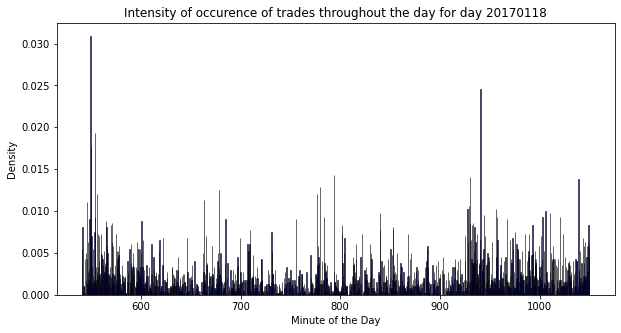

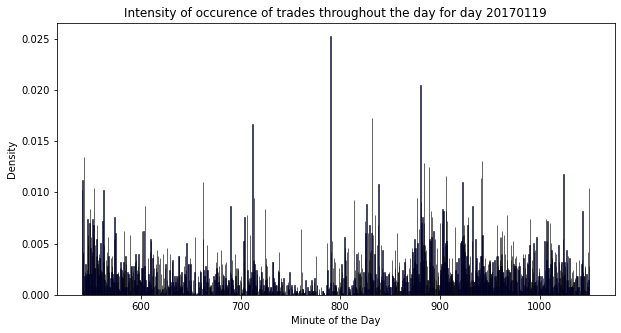

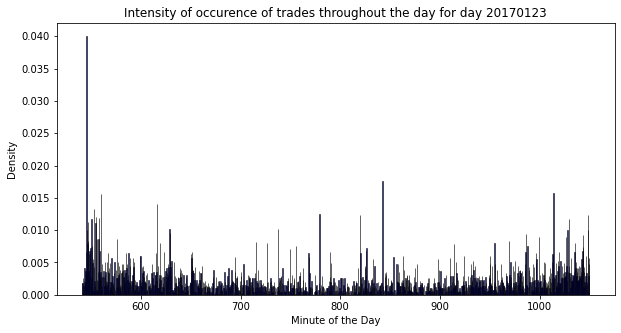

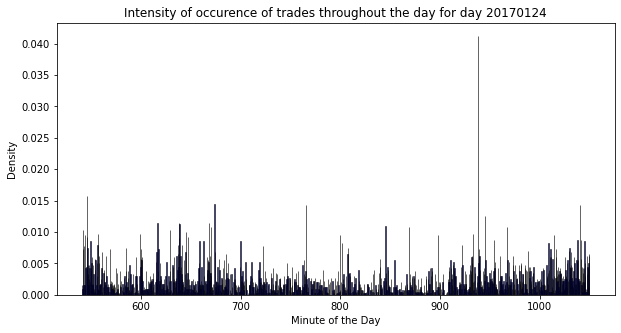

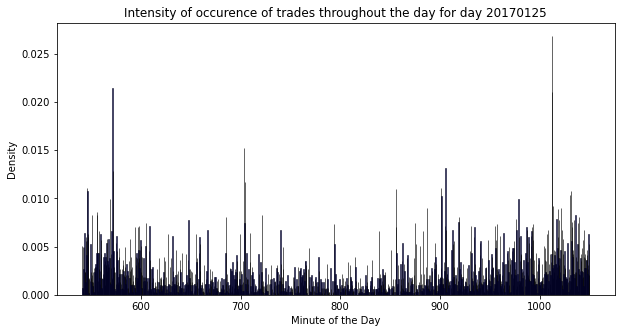

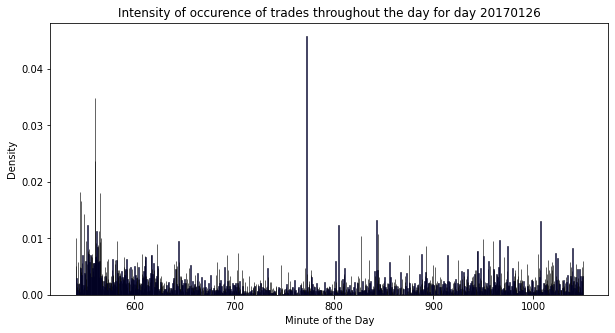

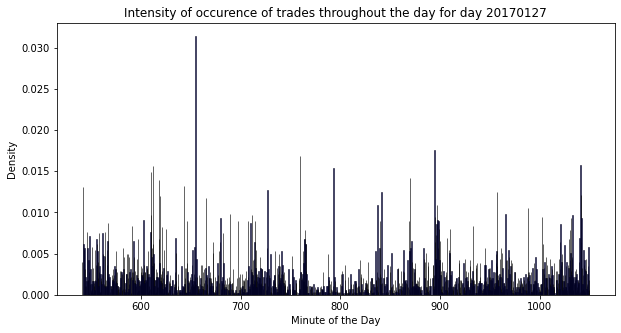

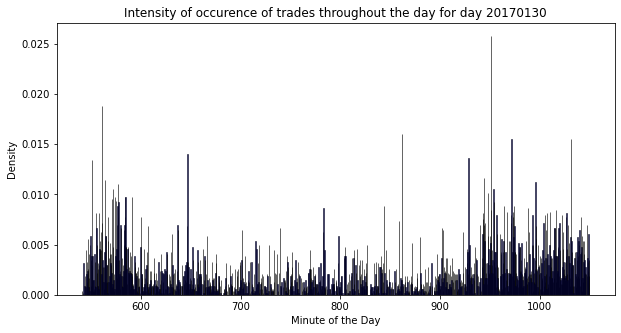

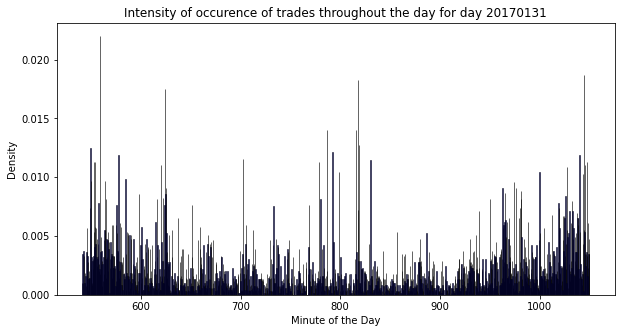

In [56]:
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    # "SG_20170120.csv.gz", # Different from the others days (spike of activity)
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
]

file_test = "SG_20170201.csv.gz"

for file in file_list:
    
    df = pd.read_csv(f'./TP/High-Frequency-Data-Limit-Order-Books/Data/SG/{file}')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df = df.loc[df['etype']=='T']
    plot_event_density(df, file)

df_test = pd.read_csv(f'./TP/High-Frequency-Data-Limit-Order-Books/Data/SG/{file_test}')
df_test.drop(df_test.columns[0], axis=1, inplace=True)
df_test['ets'] = pd.to_datetime(df_test['ets'], format="%Y%m%d:%H:%M:%S.%f")
df_test = df_test.loc[df_test['etype']=='T']

This plots represent the density of events throughout the day for each day in the dataset. We can see that the intensity of events is greater at the opening and the close. We will try to reproduce this density with our simulations

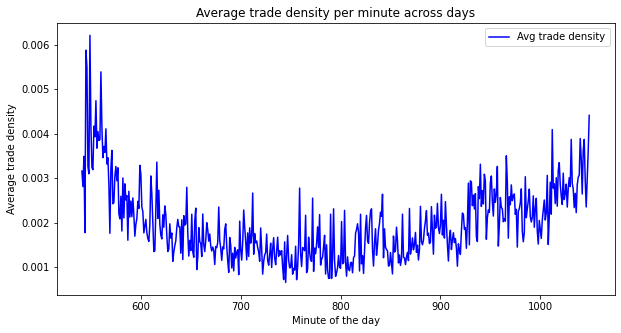

In [57]:
all_densities = []
all_nb_events = []
for file in file_list:
    df = pd.read_csv(f'./TP/High-Frequency-Data-Limit-Order-Books/Data/SG/{file}')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df = df.loc[df['etype']=='T']
    df['minute_of_day'] = df['ets'].dt.hour * 60 + df['ets'].dt.minute
    density = df.groupby('minute_of_day').size() / len(df)
    all_densities.append(density)
    all_nb_events.append(len(df))

nb_events = np.mean(all_nb_events)
avg_density = pd.concat(all_densities, axis=1).mean(axis=1).sort_index()
plt.figure(figsize=(10, 5))
plt.plot(avg_density.index, avg_density.values, label='Avg trade density', color='b')
plt.xlabel('Minute of the day')
plt.ylabel('Average trade density')
plt.title('Average trade density per minute across days')
plt.legend()
plt.show()

This plot represents the average density of trades for each minute of the day on the 11 days in the dataset.It is logically smile-shaped, as the activity is more important at the opening and the close.

C:\Users\rwill\AppData\Local\Temp\ipykernel_16712\1530410681.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_df = pd.Series()


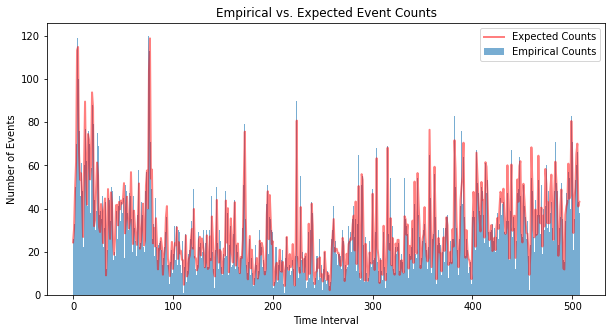

In [58]:
total_df = pd.DataFrame(all_densities).T.sort_index().fillna(0)
total_df.index = total_df.index - total_df.index[0]
col = np.arange(0, len(total_df), 1)%len(total_df.columns) #np.random.choice(total_df.columns, len(total_df))
tmp_df = pd.Series()
for i in total_df.index:
    tmp_df.loc[i] = total_df.loc[i, col[i]]

def mu_empirical(total_df, t, noise = False):
    if type(t) == np.ndarray:
        return np.array([mu_empirical(tmp_df, t_) for t_ in t])
    value_at_t = total_df.loc[int(t)]
    value_at_t_plus_1 = total_df.loc[int(t) + 1]
    interpolated_value = value_at_t + (t - int(t)) * (value_at_t_plus_1 - value_at_t)
    if noise:
        noise = 0
        return (interpolated_value + noise) * nb_events
    return interpolated_value * nb_events

nb_min = total_df.index[-1] - total_df.index[0]
T = nb_min - 1
mu_max = tmp_df.max() * nb_events
events_simulated = simulate_nonhomogeneous_poisson(T, lambda t : mu_empirical(tmp_df, t), mu_max)
plot(events_simulated, lambda t : mu_empirical(tmp_df, t), mu_max, num_intervals=nb_min)

The blue bars of this plots represent the number of events per minute of simulated events throughout one day, the red plot is the expected number of events. This plot has been obtained with an intensity function created from the empirical density observed during the 11 days of the dataset, we create this function piecewise linear by taking a pseudo-randomly density from the one of the 11 days for each minute and interpolating between every minute. 

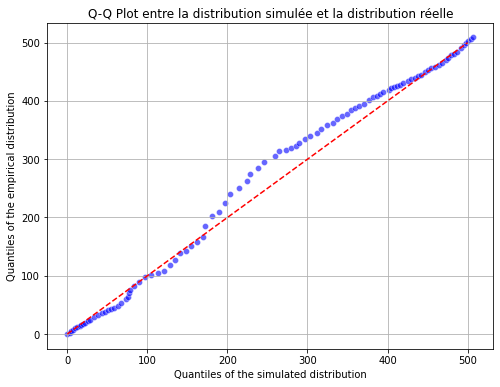

In [59]:
real_data = (df_test.ets.dt.hour*60 + df_test.ets.dt.minute + df_test.ets.dt.second / 60.0).values
real_data = real_data - real_data[0]
# Créer un Q-Q plot
pct1 = np.percentile(events_simulated, np.linspace(0, 100, 100))
pct2 = np.percentile(real_data, np.linspace(0, 100, 100))
plt.figure(figsize=(8, 6))
plt.scatter(pct1, pct2, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([0, 500], [0, 500], 'r--')
plt.title('Q-Q Plot entre la distribution simulée et la distribution réelle')
plt.xlabel('Quantiles of the simulated distribution')
plt.ylabel('Quantiles of the empirical distribution')
plt.grid(True)
plt.show()


This plot is the Q-Q plot between the observed times of events in a real test dataset (unseen for our model) and in our simulated events. We can see that the Q-Q plots fits quite well and that our model is able to simulate quite accurately the events of a trading day.